In [1]:
import json
from pathlib import Path

import dask
import dask.dataframe as dd
import dask.diagnostics
import dask.array as da
import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm
import transformers

from context_probing.utils import get_hf_data, ids_to_readable_tokens

In [2]:
datasets.disable_caching()

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [4]:
DATA_DIR = Path("data/en_lines-ud-dev/")
MODELS = ["gpt-j-6B", "gpt2-xl", "gpt2"]
METRICS_PATH_FMT = "preds/{}.en_lines-ud-dev.metrics.pth"

In [5]:
MAX_CTX = 1023

## Load the dataset

In [6]:
dataset = get_hf_data(
    DATA_DIR,
    add_positions=True,  # add the positions within the document ("positions")
    add_seq_ids=True,    # add the index of the document ("seq_id")
    columns=[
        "input_ids", "attention_mask", "ud_form", "ud_lemma", "ud_upos", "ud_xpos", "ud_deprel", "sent_id", "ud_id", "ud_head"
    ]
)

num_proc must be <= 8. Reducing num_proc to 8 for dataset of size 8.


Map (num_proc=8):   0%|          | 0/8 [00:00<?, ? examples/s]

num_proc must be <= 8. Reducing num_proc to 8 for dataset of size 8.


Map (num_proc=8):   0%|          | 0/8 [00:00<?, ? examples/s]

num_proc must be <= 8. Reducing num_proc to 8 for dataset of size 8.


Map (num_proc=8):   0%|          | 0/8 [00:00<?, ? examples/s]

In [7]:
[len(doc["input_ids"]) for doc in dataset]

[2474, 2907, 2325, 2590, 2030, 3647, 2511, 2188]

In [8]:
dataset_df = pd.concat(pd.DataFrame(seq) for seq in dataset).rename(columns={"positions": "position"})
dataset_df

,input_ids,attention_mask,ud_form,ud_lemma,ud_upos,ud_xpos,ud_deprel,ud_id,ud_head,sent_id,labels,position,seq_id
0,2215,1,When,when,SCONJ,None,mark,1,4,1,2215,0,0
1,257,1,a,a,DET,IND-SG,det,2,3,1,257,1,0
2,2836,1,user,user,NOUN,SG-NOM,nsubj,3,4,1,2836,2,0
3,20417,1,connects,connect,VERB,PRES,advcl,4,19,1,20417,3,0
4,284,1,to,to,ADP,None,case,5,9,1,284,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,683,1,him,he,PRON,PERS-P3SG-ACC,obl,4,1,1032,683,2183,7
2184,355,1,as,as,SCONJ,None,mark,5,7,1032,355,2184,7
2185,339,1,he,he,PRON,PERS-P3SG-NOM,nsubj,6,7,1032,339,2185,7
2186,11114,1,walks,walk,VERB,PRES,advcl,7,1,1032,11114,2186,7


In [9]:
seq_bounds = [0]
start_idx = 0
for ids in dataset["input_ids"]:
    end_idx = start_idx + len(ids) - 1
    seq_bounds.append(end_idx)
    start_idx = end_idx

## Load the metrics

In [10]:
def load_metrics(path):
    metrics = torch.load(path)

    # Mask out values below the diagonal
    for val in metrics.values():
        assert len(val) == seq_bounds[-1]
        for start, end in zip(seq_bounds[:-1], seq_bounds[1:]):
            if val.is_floating_point():
                assert val.ndim == 2
                val[start:end] += torch.triu(torch.full_like(val[start:end], torch.nan), diagonal=1)
            else:
                assert val.ndim == 3
                mask = torch.triu(torch.ones(val[start:end].shape[:2], dtype=val.dtype), diagonal=1)[..., None]
                val[start:end] *= 1 - mask
                val[start:end] -= mask

    return metrics

In [11]:
metrics_dict = {
    "xent": [], "kl_full": [], "imp_xent": [], "imp_kl_full": [],
    "ctx_len": [], "seq_id": [], "position": [], "model": []
}

for model in tqdm(MODELS):
    metrics = load_metrics(METRICS_PATH_FMT.format(model))

    # Fill in values below the diagonal with values from the diagonal
    for val in metrics.values():
        assert len(val) == seq_bounds[-1]
        for start, end in zip(seq_bounds[:-1], seq_bounds[1:]):
            if not val.is_floating_point():
                continue
                
            assert val.ndim == 2
            
            mask = torch.triu(torch.ones_like(val[start:end], dtype=bool), diagonal=1)
            fill_values = val[start:end][np.arange(end - start), np.arange(end - start).clip(max=val.shape[1] - 1)]
            fill_values = torch.broadcast_to(fill_values[:, None], val[start:end].shape)
            val[start:end][mask] = fill_values[mask]

    # Metrics
    metrics_dict["xent"].append(da.from_array(metrics["xent"].numpy().reshape(-1), chunks="auto"))
    shape = metrics_dict["xent"][-1].shape
    chunks = metrics_dict["xent"][-1].chunks
    metrics_dict["kl_full"].append(da.from_array(metrics["kl_full"].numpy().reshape(-1), chunks=chunks))

    # Importance scores
    for metric in ["xent", "kl_full"]:
        metrics_dict["imp_" + metric].append(
            da.from_array(
                np.pad(-metrics[metric].diff(dim=1).numpy(), [(0, 0), (1, 0)], constant_values=np.nan).reshape(-1),
                chunks=chunks
            )
        )

    # Meta-variables
    metrics_dict["ctx_len"].append(da.broadcast_to(da.arange(1, metrics["xent"].shape[-1] + 1), metrics["xent"].shape).reshape(shape).rechunk(chunks))
    for col, newcol, dtype in [("seq_id", "seq_id", int), ("positions", "position", int)]:
        metrics_dict[newcol].append(da.broadcast_to(
            da.asarray([val for ex in dataset[col] for val in ex[1:]], dtype=dtype)[:, None],
            metrics["xent"].shape
        ).reshape(shape).rechunk(chunks))
    metrics_dict["model"].append(da.from_array(np.full(shape, model, dtype=object), chunks=chunks))

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
col_names = list(metrics_dict.keys())
metrics_dd = dd.concat([
    dd.from_dask_array(da.concatenate([a for a in metrics_dict[col]]))
    for col in col_names
], axis=1)
metrics_dd.columns = col_names
metrics_dd = metrics_dd.repartition(16)
metrics_dd

,xent,kl_full,imp_xent,imp_kl_full,ctx_len,seq_id,position,model
npartitions=16,,,,,,,,
0,float32,float32,float32,float32,int64,int64,int64,object
3967488,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
59512319,...,...,...,...,...,...,...,...
63479807,...,...,...,...,...,...,...,...


## Make plots

In [13]:
Path("figs/").mkdir(exist_ok=True)

[########################################] | 100% Completed | 7.51 sms


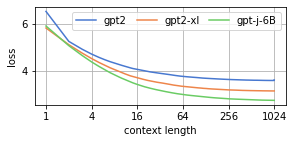

[########################################] | 100% Completed | 4.78 sms


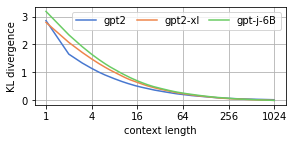

In [14]:
for metric, ylabel in [("xent", "loss"), ("kl_full", "KL divergence")]:
    with dask.diagnostics.ProgressBar():
        df = (
            metrics_dd
            .groupby(["model", "ctx_len"]).agg({metric: "mean"})
            .compute()
        )

    plt.figure(figsize=(4.5, 1.8))
    sns.lineplot(data=df, x="ctx_len", y=metric, hue="model", hue_order=MODELS[::-1], ci="none", palette="muted")
    plt.legend(ncol=3, columnspacing=1, handletextpad=0.75)
    plt.xlabel("context length")
    plt.ylabel(ylabel)
    plt.xscale("log", base=2)
    xticks = 2 ** np.arange(0, 11, 2)
    plt.xticks(xticks, xticks)
    plt.grid()
    plt.savefig(f"figs/{metric}_ctx_models.pdf", bbox_inches="tight")
    plt.show()

In [15]:
upos_counts = (    
    metrics_dd[["seq_id", "position"]]
    .drop_duplicates()
    .compute()
    .join(dataset_df.set_index(["seq_id", "position"])[["ud_upos"]], on=["seq_id", "position"])
    ["ud_upos"].value_counts()
)
upos_counts

NOUN     4085
VERB     2450
PUNCT    2226
PRON     1954
ADP      1892
DET      1801
ADJ      1509
ADV      1096
AUX      1063
PROPN     969
CCONJ     611
PART      488
SCONJ     309
NUM       130
INTJ       43
X          34
SYM         4
Name: ud_upos, dtype: int64

In [16]:
upos_filtered = upos_counts.index[upos_counts >= 100]

[########################################] | 100% Completed | 4.26 sms


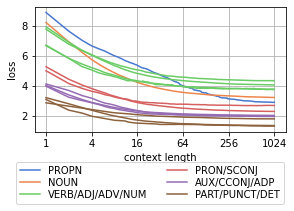

In [17]:
for metric, ylabel in [("xent", "loss")]:
    with dask.diagnostics.ProgressBar():
        df = (
            metrics_dd
            .query("model == 'gpt-j-6B'")
            .compute()
            .join(dataset_df.set_index(["seq_id", "position"])[["ud_upos"]].query("ud_upos in @upos_filtered"),
                  on=["seq_id", "position"], how="inner")
            .groupby(["ctx_len", "ud_upos"], sort=False).agg({metric: "mean"}).reset_index()
        )

    base_palette = sns.color_palette("muted")
    upos_groups = [
        ["PROPN"],
        ["NOUN"],
        ["VERB", "ADJ", "ADV", "NUM"],
        ["PRON", "SCONJ"],
        ["AUX", "CCONJ", "ADP"],
        ["PART", "PUNCT", "DET"],
    ]
    upos_order = [u for g in upos_groups for u in g]
    upos_palette = {u: base_palette[[i for i, g in enumerate(upos_groups) if u in g][0]]
                    for u in upos_order}

    plt.figure(figsize=(4.5, 2.3))
    sns.lineplot(data=df, x="ctx_len", y=metric,
                 hue="ud_upos", hue_order=upos_order,
                 palette=upos_palette,
                 ci="none")
    plt.xlabel("context length")
    plt.ylabel(ylabel)
    plt.xscale("log", base=2)
    xticks = 2 ** np.arange(0, 11, 2)
    plt.xticks(xticks, xticks)
    plt.grid()
    
    # Group legend by color
    handles, _ = plt.gca().get_legend_handles_labels()
    new_handles = []
    i = 0
    for g in upos_groups:
        new_handles.append(handles[i])
        i += len(g)
    labels = ["/".join(l for l in g) for g in upos_groups]
    plt.legend(new_handles, labels, ncol=2, labelspacing=0.2,
               loc="upper center", bbox_to_anchor=(0.46, -0.2))
    
    plt.savefig(f"figs/{metric}_ctx_upos.pdf", bbox_inches="tight")
    plt.show()

[####                                    ] | 11% Completed | 127.21 ms

/var/folders/cc/srzlbdjs5ps0b7t0yyl1lhc80000gn/T/ipykernel_37334/217159532.py:11: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(norm_importances)


[########################################] | 100% Completed | 69.01 ss


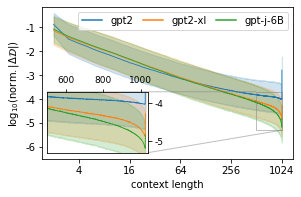

In [18]:
def norm_importances(df):
    imp_norm = np.abs(df["imp_kl_full"])
    imp_norm /= imp_norm.sum()
    return df.assign(imp_norm=imp_norm)

with dask.diagnostics.ProgressBar():
    df = (
        metrics_dd
        [["imp_kl_full", "ctx_len", "model", "seq_id", "position"]]
        .groupby(["model", "seq_id", "position"])
        .apply(norm_importances)
        .dropna(subset="imp_norm")
        .eval("log_imp_norm = log(imp_norm + @eps) / log(10)",
              local_dict=dict(eps=np.finfo(np.float32).eps))
        .compute()
    )

plt.figure(figsize=(4.5, 2.8))
def plot(**kwargs):
    sns.lineplot(
        data=(
            df
            .query("position >= @MAX_CTX")
        ),
        x="ctx_len", y="log_imp_norm", hue="model", hue_order=MODELS[::-1], ci="sd",
        lw=0.85,
        **kwargs
    )
plot()
plt.xscale("log", base=2)
plt.ylim(bottom=-6.5)
plt.gca().xaxis.set_major_formatter("{x:0.0f}")
plt.gca().yaxis.set_major_formatter("{x:0.0f}")
plt.xlabel("context length")
plt.ylabel(r"$\log_{10}(\mathrm{norm. }|\Delta\mathcal{D}|)$")
plt.legend(ncol=3, columnspacing=1)

ax_in = plt.gca().inset_axes((0.02, 0.04, 0.4, 0.4))
plot(ax=ax_in, legend=False)
ax_in.xaxis.tick_top()
ax_in.yaxis.tick_right()
ax_in.tick_params(axis="both", labelsize=9)
ax_in.set_yticks([-5, -4])
ax_in.set_yticklabels([])
ax_in.set_xlim(500, 1036)
ax_in.set_ylim(-5.3, -3.7)
ax_in.xaxis.set_major_formatter("{x:0.0f}")
ax_in.yaxis.set_major_formatter("{x:0.0f}")
ax_in.set_xlabel(None)
ax_in.set_ylabel(None)
x0, x1 = ax_in.get_xbound()
y0, y1 = ax_in.get_ybound()
plt.gca().indicate_inset((x0, y0, x1-x0, y1-y0), inset_ax=ax_in)

plt.savefig("figs/ctx_len_vs_imp.pdf", bbox_inches="tight")
plt.show()

[########################################] | 100% Completed | 11.52 ss


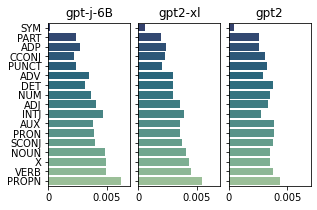

In [19]:
metric = "imp_kl_full"

with dask.diagnostics.ProgressBar():
    df = (
        metrics_dd
        .eval("ctx_pos = position - ctx_len")
        [[metric, "model", "seq_id", "position", "ctx_pos"]]
        .compute()
        .join(
            dataset_df[["seq_id", "position", "ud_upos"]]
            .set_index(["seq_id", "position"]),
            on=["seq_id", "ctx_pos"]
        )
        .rename(columns={"ud_upos": "ctx_upos"})
    )

    order = (
        df
        .query(f"not {metric}.isna()")
        .groupby("ctx_upos").mean()
        .sort_values(by=metric)
        .index
    )

    
fig, axes = plt.subplots(1, 3, figsize=(4.7, 3), sharey=True, tight_layout=True, gridspec_kw=dict(wspace=0.1))

for model, ax in zip(MODELS, axes.flat):
    sns.barplot(
        data=(
            df
            .query("model == @model")
            .groupby(["ctx_upos"])[[metric]].mean()
            .reset_index()
        ),
        y="ctx_upos", x=metric, ci="sd",
        order=order, palette="crest_r",
        ax=ax)
    ax.set_xlim(0, 0.007)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g'))
    ax.set_title(model)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

plt.savefig("figs/imp_by_upos_by_model.pdf", bbox_inches="tight")
plt.show()

In [20]:
def plot_context(model, seq_id, idx, metric, ctx_len=None, n_drops=10, print_context=True, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    metrics_path = Path(METRICS_PATH_FMT.format(model))
    metrics = load_metrics(metrics_path)

    start, end = seq_bounds[seq_id:seq_id + 2]
    values = metrics[metric][start + idx - 1][:idx]
    values = values[:ctx_len]
    g = ax.plot(np.arange(len(values)) + 1, values, **kwargs)
    ax.invert_xaxis()
    ax.set_xscale("log", base=2)
    xticks = 2 ** np.arange(0, 11, 2)
    ax.set_xticks(xticks, xticks)
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    
    context = ids_to_readable_tokens(
        tokenizer,
        dataset["input_ids"][seq_id][:idx + 1][-len(values):],
        strip_whitespace=False
    )
    
    if n_drops:
        drops = values.diff().topk(n_drops, largest=False)
        for c in list(drops.indices)[::-1]:
            ax.scatter(c + 2, values[c + 1], color="red", s=16, zorder=2)
            text = ax.annotate(context[len(context) - c - 3].replace(" ", "␣"), (c + 2, values[c + 1]),
                               fontsize=12, xytext=(6, 0), textcoords="offset pixels")
            text.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="white"))

    if print_context:
        print("..." + "".join(context[-61:-1]), "->", context[-1].replace(" ", "␣"))

    return g

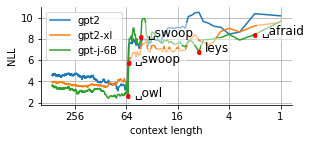

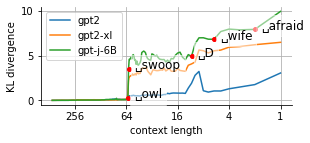

In [21]:
for metric, ylabel in [("xent", "NLL"), ("kl_full", "KL divergence")]:
    plt.figure(figsize=(4.5, 1.8))
    for model in ["gpt2", "gpt2-xl", "gpt-j-6B"]:
        plot_context(model, 6, 469, metric, n_drops=(5 if model == "gpt-j-6B" else 0), print_context=False, label=model)
    if metric == "xent":
        plt.ylim(1.8, 11)
        plt.yticks(range(2, 11, 2))
    plt.grid()
    plt.legend()
    plt.xlabel("context length")
    plt.ylabel(ylabel)
    plt.savefig(f"figs/{metric}_ex_birds_small.pdf", bbox_inches="tight")
    plt.show()

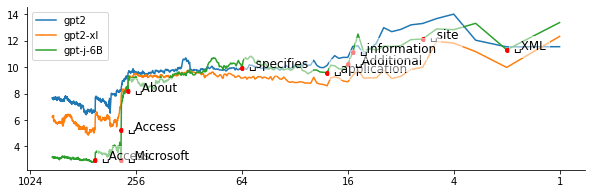

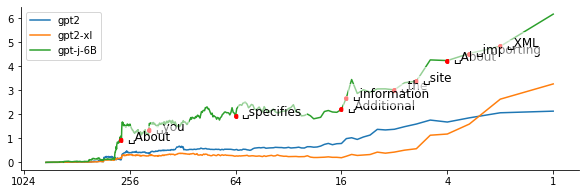

In [22]:
for metric in ["xent", "kl_full"]:
    plt.figure(figsize=(10, 3))
    for model in ["gpt2", "gpt2-xl", "gpt-j-6B"]:
        plot_context(model, 0, 766, metric, n_drops=(10 if model == "gpt-j-6B" else 0),
                     print_context=False, label=model)
    plt.legend()
    plt.savefig(f"figs/{metric}_ex_Access.pdf", bbox_inches="tight")
    plt.show()

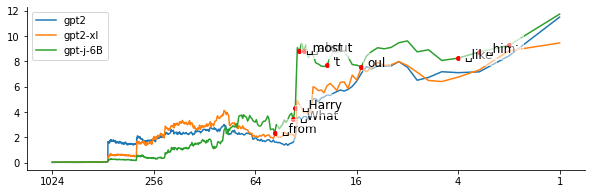

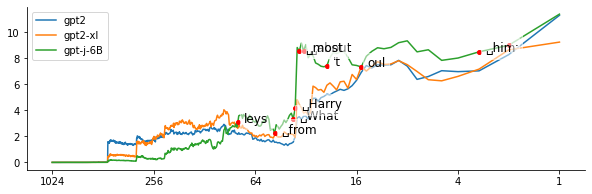

In [23]:
for metric in ["xent", "kl_full"]:
    plt.figure(figsize=(10, 3))
    for model in ["gpt2", "gpt2-xl", "gpt-j-6B"]:
        plot_context(model, 6, 2385, metric, n_drops=(10 if model == "gpt-j-6B" else 0),
                     print_context=False, label=model)
    plt.legend()
    plt.savefig(f"figs/{metric}_ex_Weasley.pdf", bbox_inches="tight")
    plt.show()

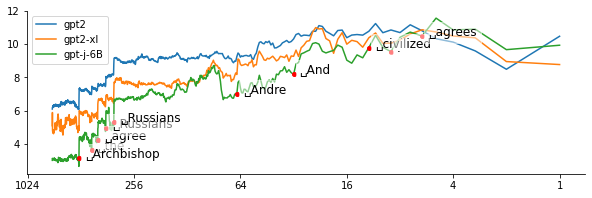

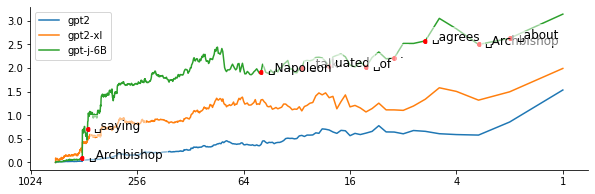

In [24]:
for metric in ["xent", "kl_full"]:
    plt.figure(figsize=(10, 3))
    for model in ["gpt2", "gpt2-xl", "gpt-j-6B"]:
        plot_context(model, 2, 742, metric, n_drops=(10 if model == "gpt-j-6B" else 0),
                     print_context=False, label=model)
    plt.legend()
    plt.savefig(f"figs/{metric}_ex_Russians.pdf", bbox_inches="tight")
    plt.show()

## Save data for the demo

In [25]:
for model in tqdm(MODELS):
    metrics_path = Path(METRICS_PATH_FMT.format(model))
    metrics = load_metrics(metrics_path)

    for seq_id, (start, end) in enumerate(zip(tqdm(seq_bounds[:-1], leave=False), seq_bounds[1:])):
        prefix = f"{metrics_path.stem.replace('.metrics', '')}.{seq_id:05d}"

        for metric, suffix in [("xent", ".xentdiff.npy"), ("kl_full", ".kldiff.npy")]:
            # Compute diffs
            xent_diffs = np.diff(metrics[metric][start:end], axis=1)
            xent_diffs = np.pad(xent_diffs, [(1, 0), (0, 0)], constant_values=np.nan)
            xent_diffs = np.ma.masked_array(xent_diffs, np.isnan(xent_diffs))
            xent_diffs_norm = xent_diffs / np.max(np.abs(xent_diffs), axis=1, keepdims=True)
            xent_diffs_norm = np.ascontiguousarray(xent_diffs_norm.data)  # C-order needed for npyjs

            # Quantize to save space
            xent_diffs_int8 = np.nan_to_num(xent_diffs_norm) * (127.5 - 1e-4)
            assert (np.abs(xent_diffs_int8) < 127.5).all()
            xent_diffs_int8 = np.rint(xent_diffs_int8).astype(np.int8)
            # Check that we recover the original values with the right precision
            assert (
                np.nan_to_num(np.abs(xent_diffs_int8.astype(np.float32) / 127 - xent_diffs_norm))
                <= 1/(127 + 1e-4)
            ).all()
            np.save(Path("www/static/data") / (prefix + suffix), xent_diffs_int8, allow_pickle=False)

        # Save top-k
        topk = np.asarray(metrics["topk"][start:end, :, :5])
        topk = np.pad(topk, [(1, 0), (0, 0), (0, 0)], constant_values=-1)
        topk = np.ascontiguousarray(topk)
        np.save(Path("www/static/data") / (prefix + ".topk.npy"), topk, allow_pickle=False)

all_tokens = []
for seq_id, (start, end) in enumerate(zip(seq_bounds[:-1], seq_bounds[1:])):
    tokens = ids_to_readable_tokens(tokenizer, dataset[seq_id]["input_ids"], strip_whitespace=False)
    all_tokens.append(tokens)

dataset_name = metrics_path.stem.split(".")[1]
with open(Path("www/data") / f"{dataset_name}.tokens.json", "w") as f:
    json.dump(all_tokens, f)
with open(Path("www/static/data") / f"inv_vocab.json", "w") as f:
    json.dump(
        {
            i: tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(i))
            for i in sorted(tokenizer.vocab.values())
        },
        f
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]